##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024
### TP1 - Recherche de documents avec une métrique de similarité


## Identification de l'équipe:

### Groupe de laboratoire:

### Equipe numéro :

### Membres:

- membre 1 (% de contribution, nature de la contribution)
- membre 2 (% de contribution, nature de la contribution)
- membre 3 (% de contribution, nature de la contribution)

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

## Mise en place

### Objectif du TP

La recherche d'information est le processus d'accès aux données, généralement des documents ou d'autres données non structurées, à partir d'une requête. Dans ce TP, vous aurez en entrée une requête textuelle sous forme d'affirmation. Il faudra retrouver dans un corpus de littérature scientifique les documents pertinents qui justifient ou infirment la véracité de cette affirmation. Vous utiliserez des modèles vectoriels et des métriques de similarité pour cette tâche.

### Jeux de données

Dans ce TP, vous utiliserez le jeu de données dans le répertoire _data_. Il s'agit d'un ensemble de données comprenant 809 affirmations rédigées par des experts et 5183 documents de références pour ces affirmations. Ces documents contiennent des phrases qui confirment ou infirment (contredisent) les affirmations. L'objectif est donc de trouver un document pertinent, c'est-à-dire contenant la ou les phrases qui permettent d'évaluer une affirmation donnée en entrée en utilisant une similarité sémantique. 

Le jeu de données comprend :

1. Un corpus (_corpus.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'doc_id' : permet d'identifier le document en entrée
    - 'title' : donne le titre du document
    - 'abstract': est le résumé du document
    - 'structured': indique si le document est structuré ou pas

2. Un ensemble d'affirmations (_claims.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'id' : identifie l'affirmation.
    - 'claim' : est l'affirmation en tant que telle.
    - 'evidence' : précise quelles phrases du document sont pertinentes pour l'affirmation. Chaque phrase est accompagnée d'une étiquette de véracité (confirm/contradict) pour indiquer si la phrase confirme ou contredit l'affirmation.  
    - 'cited_doc_ids' : indique les identifiants des documents cités.



Dans _claims.jsonl_, seuls les identifiants des documents sont renseignés. Pour avoir les détails d'un document tel que le titre ("title") et le résumé ("abstract"), il faudra consulter le fichier _corpus.jsonl_. 

Voici un exemple :

- **Affirmation (claim)** : Consumption of whole fruits increases the risk of type 2 diabetes.
- **Cited document(s) ID(s)** : 1974176
- **Evidence (sentence in the document containing the proof)** : [{'sentences': [11], 'label': 'CONTRADICT'}]

  Ici [11] constitue le numéro de la phrase qui contredit l'affirmation.

- **Cited document(s) title(s)** : Fruit consumption and risk of type 2 diabetes: results from three prospective longitudinal cohort studies
- **Cited document(s) abstract(s) (list of sentences)** : 
    - [0] 'OBJECTIVE To determine whether individual fruits are differentially associated with risk of type 2 diabetes.\n'
    - [1] 'DESIGN Prospective longitudinal cohort study.'
    - ...
    - [10] 'CONCLUSION Our findings suggest the presence of heterogeneity in the associations between individual fruit consumption and risk of type 2 diabetes.'
    - [11] 'Greater consumption of specific whole fruits, particularly blueberries, grapes, and apples, is significantly associated with a lower risk of type 2 diabetes, whereas greater consumption of fruit juice is associated with a higher risk.'

Le champ "evidence" indique la phrase au niveau du résumé du document qui confirme ou infirme l'affirmation, d'où le numéro de la phrase et le label qui y sont renseignés. Dans le cas particulier de l'exemple ci-dessus, on voit bien que la onzième phrase du résumé du document est la plus pertinente pour l'affirmation et qu'elle la contredit, ce qui explique le label "CONTRADICT" dans "evidence". Cependant, dans le cadre de ce TP, on ne s'intéresse qu'à la présence de cette phrase pertinente dans le document, donc on ne considérera pas cette colonne "evidence" dans la suite du TP.

### Librairies permises
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- PowerLaw
- Matplotlib
- TQDM
- BM25
- Pour toute autre librairie, demandez à votre chargé de laboratoire

## Étapes du TP
A partir du notebook _INF8460_A24_TP1_ qui est distribué, vous devez réaliser les étapes suivantes. (Notez que les cellules dans le squelette sont là à titre informatif - il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

In [1]:
# Lien vers les fichiers à utiliser
# Ne pas modifier

PATH = 'data/ai2_data/'

In [2]:
!pip install rank_bm25 
!pip install powerlaw

In [3]:
# Import des librairies

import numpy as np
import pandas as pd
import powerlaw
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Dict

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from rank_bm25 import BM25Okapi

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\teefr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\teefr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### 1. Traitement des données (15 points)
Vous allez effectuer une analyse afin d'avoir une idée claire des données que vous aurez à manipuler.

#### 1.1 Chargement des données (2 points)

##### 1.1.1 Chargement et affichage des données (1 point)

Chargez les données '_claims.jsonl_' et '_corpus.jsonl_' puis affichez-les dans des dataframes en utilisant panda.

In [6]:
# TODO
df_claims = pd.read_json(PATH+'/claims.jsonl', lines=True)
df_corpus = pd.read_json(PATH+'/corpus.jsonl', lines=True)

df_claims
# print(df_corpus.head())
# END TODO

,id,claim,evidence,cited_doc_ids
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818]
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012]
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787]
3,6,10% of sudden infant death syndrome (SIDS) dea...,{},[2613775]
4,9,32% of liver transplantation programs required...,"{'44265107': [{'sentences': [15], 'label': 'SU...",[44265107]
...,...,...,...,...
804,1403,siRNA knockdown of A20 accelerates tumor progr...,"{'33370': [{'sentences': [6], 'label': 'CONTRA...","[33370, 38355793]"
805,1404,siRNA knockdown of A20 slows tumor progression...,"{'33370': [{'sentences': [6], 'label': 'SUPPOR...","[33370, 38355793]"
806,1405,taa1 tar1 tar2 triple mutants in Arabidopsis d...,{},[10504681]
807,1406,β-sheet opening occurs during pleurotolysin po...,"{'2617858': [{'sentences': [4], 'label': 'SUPP...",[2617858]


##### 1.1.2 Statistique sur les évidences (1 point)

Calculez les pourcentages d'apparition de chaque label des évidences dans "_df_claims_" (CONTRADICT ou SUPPORT). Pour rappel les évidences sont les extraits pertinents des résumés qui supportent ou contredisent les affirmations. 

In [12]:
# On calcule les pourcentages des labels present dans evidence
# TODO
nb_contradict = 0
nb_support = 0
evidence = df_claims['evidence']
for data in evidence : 
    for value in data.values() : 
        #print(value)
        for sentence in value : 
            #print(sentence)
            if sentence['label'] == 'SUPPORT' : 
                nb_support += 1 
            else : 
                nb_contradict += 1 

total = nb_support+nb_contradict 
nb_support_perc = nb_support/total 
nb_contradict_perc = nb_contradict/total
print(f'nb_support {nb_support} nb_contradict {nb_contradict}')
print(f'nb_support_perc {nb_support_perc} nb_contradict {nb_contradict_perc}')
# END TODO

nb_support 616 nb_contradict 341
nb_support_perc 0.6436781609195402 nb_contradict 0.3563218390804598


> Réponse attendue:
> 
> CONTRADICT: 35.63%
> 
> SUPPORT: 64.37%

#### 1.2 Analyse statistique des données (7 points)

Nous allons faire une suite de transformations sur les données pour les rendre plus faciles à manipuler.

##### 1.2.1 Implémentation de la fonction "_list_to_string_" 

Nous mettons à votre disposition la fonction "_list_to_string_" qui transforme une liste de phrases en un texte en les concaténant et enlèvant tous les caractères de nouvelle ligne (`\n`) pour s'assurer que nous avons un texte complet. 

In [20]:
# On transforme la liste de phrases en un texte
def list_to_string(x):
    if isinstance(x, list):
        return ' '.join(str(i).replace("\n","").replace("  "," ") for i in x)  # Enlève les caractère de retour à la ligne et convertit les éléments de la liste en chaînes et les joint
    return str(x)

##### 1.2.2 Utilisation de la fonction "_list_to_string_" 

Appliquons cette fonction "_list_to_string_" aux colonnes "_title_" et "abstract" du dataframe "_df_corpus_".

In [39]:
# On applique la fonction aux colonnes "title" et "abstract"
df_corpus['title']    = df_corpus['title'].apply(list_to_string)
df_corpus['abstract'] = df_corpus['abstract'].apply(list_to_string)
df_corpus

,doc_id,title,abstract,structured,title_length,abstract_length,text,text_length,texts_preprocessed,titles_preprocessed,abstracts_preprocessed
0,4983,microstructural development of human newborn c...,alterations of the architecture of cerebral wh...,False,17,278,microstructural development of human newborn c...,295,"[[], [], [c], [r], [], [], [], [r], [u], [c], ...","[[c, r, r, u, c, u, r, l], [e, v, e, l, p, e, ...","[[l, e, r, n], [f], [h, e], [r, c, h, e, c, u,..."
1,5836,induction of myelodysplasia by myeloid-derived...,myelodysplastic syndromes (mds) are age-depend...,False,7,201,induction of myelodysplasia by myeloid-derived...,208,"[[], [n], [], [u], [c], [], [], [], [n], [ ], ...","[[n, u, c, n], [f], [e, l, p, l], [b], [e, l, ...","[[e, l, p, l, c], [n, r, e], [], [], [], [r, e..."
2,7912,"bc1 rna, the transcript from a master gene for...",id elements are short interspersed elements (s...,False,20,180,"bc1 rna, the transcript from a master gene for...",200,"[[b], [c], [1], [ ], [r], [n], [], [], [ ], []...","[[b, c, 1], [r, n], [], [h, e], [r, n, c, r, p...","[[], [e, l, e, e, n], [r, e], [h, r], [n, e, r..."
3,18670,the dna methylome of human peripheral blood mo...,dna methylation plays an important role in bio...,False,9,238,the dna methylome of human peripheral blood mo...,247,"[[], [h], [e], [ ], [], [n], [], [ ], [], [e],...","[[h, e], [n], [e, h, l, e], [f], [h, u, n], [p...","[[n], [e, h, l, n], [p, l], [n], [p, r, n], [r..."
4,19238,the human myelin basic protein gene is include...,two human golli (for gene expressed in the oli...,False,21,241,the human myelin basic protein gene is include...,262,"[[], [h], [e], [ ], [h], [u], [], [], [n], [ ]...","[[h, e], [h, u, n], [e, l, n], [b, c], [p, r, ...","[[w], [h, u, n], [g, l, l], [], [f, r], [g, e,..."
...,...,...,...,...,...,...,...,...,...,...,...
5178,195689316,body-mass index and cause-specific mortality i...,background the main associations of body-mass ...,True,15,413,body-mass index and cause-specific mortality i...,428,"[[b], [], [], [], [], [], [], [], [], [ ], [],...","[[b], [n, e, x], [n], [c, u, e, p, e, c, f, c]...","[[b, c, k, g, r, u, n], [h, e], [n], [c, n], [..."
5179,195689757,targeting metabolic remodeling in glioblastoma...,a key aberrant biological difference between t...,False,6,159,targeting metabolic remodeling in glioblastoma...,165,"[[], [], [r], [g], [e], [], [], [n], [g], [ ],...","[[r, g, e, n, g], [e, b, l, c], [r, e, e, l, n...","[[], [k, e], [b, e, r, r, n], [b, l, g, c, l],..."
5180,196664003,signaling architectures that transmit unidirec...,a signaling pathway transmits information from...,False,8,246,signaling architectures that transmit unidirec...,254,"[[], [], [g], [n], [], [l], [], [n], [g], [ ],...","[[g, n, l, n, g], [r, c, h, e, c, u, r, e], [h...","[[], [g, n, l, n, g], [p, h, w], [r, n], [n, f..."
5181,198133135,"association between pre-diabetes, type 2 diabe...",aims trabecular bone score (tbs) is a surrogat...,True,14,233,"association between pre-diabetes, type 2 diabe...",247,"[[], [], [], [], [c], [], [], [], [], [], [n],...","[[c, n], [b, e, w, e, e, n], [p, r, e, b, e, e...","[[], [r, b, e, c, u, l, r], [b, n, e], [c, r, ..."


##### 1.2.3 Ajout de la colonne "_text_" dans "df_corpus"


Ajoutons maintenant une colonne "_text_" qui est la concaténation du titre ("_title_") et du résumé ("_abstract_") au niveau du dataframe "df_corpus".

In [22]:
# On concatene les textes dans "title" et "abstract"
df_corpus['text'] = df_corpus['title'] + " " + df_corpus['abstract']

##### 1.2.4 Ajout de colonnes dans "_df_claims_" (1 point)

Ajoutez les colonnes "_claim_length_" et "_num_cited_doc_" qui donnent, pour chaque affirmation, le nombre de mots dans la colonne "_claim_" et le nombre de documents cités au niveau de la colonne "_cited_doc_ids_" pour le dataframe "_df_claims_". Vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [23]:
# TODO
df_claims['claim_length'] = df_claims['claim'].apply(lambda x: len(str(x).split()))
df_claims['num_cited_doc'] = df_claims['cited_doc_ids'].apply(lambda x: len(x))

df_claims

# END TODO

,id,claim,evidence,cited_doc_ids,claim_length,num_cited_doc
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818],5,1
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012],10,1
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787],12,1
3,6,10% of sudden infant death syndrome (SIDS) dea...,{},[2613775],16,1
4,9,32% of liver transplantation programs required...,"{'44265107': [{'sentences': [15], 'label': 'SU...",[44265107],13,1
...,...,...,...,...,...,...
804,1403,siRNA knockdown of A20 accelerates tumor progr...,"{'33370': [{'sentences': [6], 'label': 'CONTRA...","[33370, 38355793]",14,2
805,1404,siRNA knockdown of A20 slows tumor progression...,"{'33370': [{'sentences': [6], 'label': 'SUPPOR...","[33370, 38355793]",14,2
806,1405,taa1 tar1 tar2 triple mutants in Arabidopsis d...,{},[10504681],14,1
807,1406,β-sheet opening occurs during pleurotolysin po...,"{'2617858': [{'sentences': [4], 'label': 'SUPP...",[2617858],7,1


##### 1.2.5 Ajout des colonnes de mesures de longeurs de textes (documents) (1 point)

Ajoutez les colonnes "_title_length_", "_abstract_length_" et "_text_length_" qui donnent le nombre de mots dans les colonnes "_title_", "_abstract_" et "_text_" du dataframe "_df_corpus_". Pour le reste du TP, nous définirons la longueur du "_title_", "_abstract_" et du "_text_" comme étant le nombre de mots dans les chaînes de caractères respectives. Encore une fois, vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [25]:
# TODO
df_corpus['title_length'] = df_corpus['title'].apply(lambda x: len(str(x).split()))
df_corpus['abstract_length'] = df_corpus['abstract'].apply(lambda x: len(str(x).split()))
df_corpus['text_length'] = df_corpus['text'].apply(lambda x: len(str(x).split()))
# df_corpus
# END TODO

##### 1.2.6 Analyse statistique (1.5 point)

Faites l'analyse statistique des données en affichant le "_min_", le "_max_" et la "_moyenne_" pour les deux colonnes "_claim_length_" et "_num_cited_doc_" que vous venez de créer.

In [29]:
# TODO
# Min, max et moyenne des colonnes 'claim_length' et 'num_cited_doc' de df_claims
min_claim_length = df_claims['claim_length'].min()
max_claim_length = df_claims['claim_length'].max()
mean_claim_length = df_claims['claim_length'].mean()

min_num_cited_doc = df_claims['num_cited_doc'].min()
max_num_cited_doc = df_claims['num_cited_doc'].max()
mean_num_cited_doc = df_claims['num_cited_doc'].mean()

print(min_claim_length, max_claim_length, mean_claim_length)
print(min_num_cited_doc, max_num_cited_doc, mean_num_cited_doc)
# END TODO

3 39 12.332509270704573
1 5 1.1359703337453646


##### 1.2.7 Histogrammes (2 points)

En considérant le dataframe du corpus de résumés ("_df_corpus_"), affichez dans 3 histogrammes les distributions suivantes:

- Fréquence des titres ('_title_') en fonction de leur longueur
- Fréquence des résumés ('_abstract_') en fonction de leur longueur
- Fréquence des textes ('_text_') en fonction de leur longueur

Utilisez la valeur de 30 pour le paramètre "_bins_"

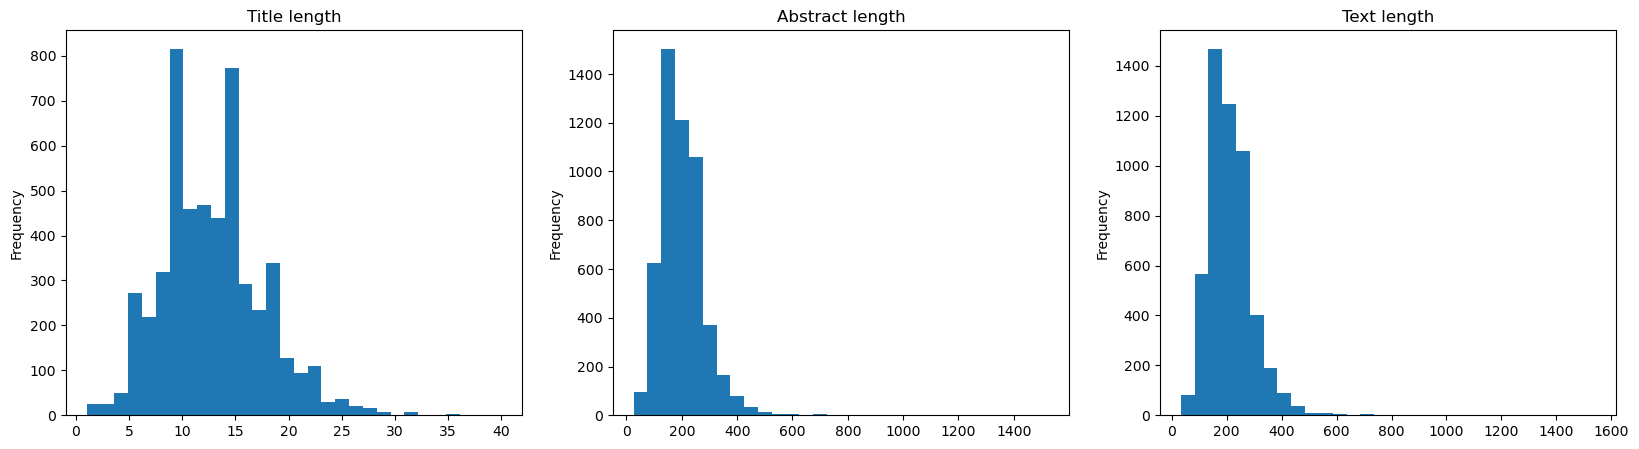

In [31]:
# TODO
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
df_corpus['title_length'].plot(kind='hist', bins=30, ax=axes[0], title='Title length')
df_corpus['abstract_length'].plot(kind='hist', bins=30, ax=axes[1], title='Abstract length')
df_corpus['text_length'].plot(kind='hist', bins=30, ax=axes[2], title='Text length')
plt.show()

# END TODO

##### 1.2.8 Quelles remarques faites-vous sur les affirmations (claims) et les documents ? (1.5 points) 

En observant les maximums, les minimums et les moyennes, que remarquez-vous à propos des affirmations ('_claims_') ? À l'aide des graphiques générés, comparez également les documents.

In [ ]:
# TODO

# END TODO

#### 1.3 Pré-traitement (6 points)
Les affirmations et résumés de texte de votre ensemble de données doivent d’abord être représentés et indexés pour ensuite pouvoir effectuer une recherche de document (pouvant être "_title_", "_abstract_" ou la fusion des deux représentée par "_text_") qui justifie/contredit une affirmation. Vous devez donc implémenter une étape de pré-traitement des données.

##### 1.3.1 Implémentation de la fonction "_tokenize_sentence_" (1 point)

Implémentez la fonction "_tokenize_sentence_" pour la segmentation d'une phrase en une liste de jetons. Utilisez la librarie `nltk`.

In [33]:
# TODO
# Implémentez la fonction "_tokenize_sentence_" pour la segmentation d'une phrase en une liste de jetons. Utilisez la librarie `nltk`.
def tokenize_sentence(sentence: str) -> List[str]:
    return word_tokenize(sentence)
# END TODO

['Th', ';', 'is', 'is', 'a', 'sentence', '.']

##### 1.3.2 Implémentation de la fonction "_tokenize_text_" (1 point)
Implémentez la fonction "_tokenize_text_" qui utilise "_tokenize_sentence_" pour faire la segmentation d'un texte (liste de phrases).

In [ ]:
# TODO
def tokenize_text(text: List[str]) -> List[str]:
    return [tokenize_sentence(sentence) for sentence in text]
# END TODO
tokenize_text(df_corpus['text'][:2])

##### 1.3.3 Implémentation de la fonction "_stem_tokens_" (1 point)

Implémentez la fonction "_stem_tokens_" qui prend une liste de jetons (tokens) en entrée et retourne une liste contenant leur forme racinisée (stems) en utilisant l'algorithme de racinisation PorterStemmer de la bibliothèque nltk.

In [ ]:
# TODO
def stem_tokens(tokens: List[str]) -> List[str]:
    porter = PorterStemmer()
    return [porter.stem(token) for token in tokens]
# END TODO

##### 1.3.4 Pré-traitement (2 points)

En utilisant vos précédentes fonctions, faites maintenant le pré-traitement des champs "_text_", "_title_" et "_abstract_" du dataframe "_df_corpus_" et "_claim_" du dataframe "_df_claims_" en suivant les étapes suivantes:
- conversion en minuscules
- segmentation (tokenization) des passages
- suppression des stop-words et ponctuation
- racinisation (stemming) des jetons

Nommez la liste des affirmations pré-traitées par "_claims_preprocessed_". Pour le corpus de documents considérez les ensembles de titres "_title_", de résumés "abstract" et la fusion des deux "_text_" et nommez les listes correspondantes par "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_" respectivement.

In [41]:
# TODO
def preprocess(text: str) -> List[str]:
    text = text.lower()
    tokens = tokenize_sentence(text)
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    tokens = stem_tokens(tokens)
    return tokens

df_corpus['texts_preprocessed'] = df_corpus['text'].apply(preprocess)
df_corpus['titles_preprocessed'] = df_corpus['title'].apply(preprocess)
df_corpus['abstracts_preprocessed'] = df_corpus['abstract'].apply(preprocess)

df_claims['claims_preprocessed'] = df_claims['claim'].apply(preprocess)
# END TODO

##### 1.3.5 Jetons uniques (types) (1 point)

Affichez maintenant le nombre total de jetons dans tous les textes (_text_) et affirmations (_claim_) (en les considérant comme un seul corpus) après le pré-traitement. Puis, affichez le nombre de jetons uniques (types) dans les textes (_text_) et les affirmations (_claim_). 

In [44]:
# TODO

# Nombre total de jetons dans les textes
total_tokens_text = df_corpus['texts_preprocessed'].apply(len).sum()
total_tokens_claim = df_claims['claims_preprocessed'].apply(len).sum()

unique_tokens_text = len(set([token for text in df_corpus['texts_preprocessed'] for token in text]))
unique_tokens_claim = len(set([token for claim in df_claims['claims_preprocessed'] for token in claim]))

print(f'Total tokens in text: {total_tokens_text}')
print(f'Total tokens in claim: {total_tokens_claim}')
print(f'Unique tokens in text: {unique_tokens_text}')
print(f'Unique tokens in claim: {unique_tokens_claim}')

# END TODO

Total tokens in text: 735052
Total tokens in claim: 7150
Unique tokens in text: 44969
Unique tokens in claim: 2416


### 2. Représentation des affirmations et des documents  (45 points)

#### 2.1  Vocabulaire (15 points)

##### 2.1.1 Implémentation de la fonction "_get_vocab_" (3 points)

Implémentez la fonction "_get_vocab_" qui prend une liste de textes composés chacun d'une liste de jetons et retourne un dictionnaire dont les clés sont les jetons uniques et les valeurs sont leur fréquence dans l'ensemble des textes.

In [8]:
# TODO
# END TODO

##### 2.1.2 Implémentez la fonction "_show_top_N_types_" (3 points)

Implémentez la fonction "show_top_N_types" qui affiche les N jetons les plus fréquents à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_".

La fonction prend deux arguments: le dictionnaire "_dictionary_" et le paramètre "_N_". 

In [9]:
# TODO
# END TODO

##### 2.1.3 Construction du vocabulaire (1 point)

Construisez maintenant le vocabulaire pour les affirmations et le corpus de documents à partir des listes "texts_preprocessed" et "claims_preprocessed". 

Ensuite affichez les 15 jetons les plus fréquents ainsi que leur fréquence.

In [10]:
# TODO
# END TODO

Sortie attendue:

```Nombre de types composant le vocabulaire: 45195
Les 15 types les plus fréquents:
('cell', 10464)
('patient', 4175)
('activ', 4145)
('studi', 4014)
('use', 3799)
('express', 3626)
('result', 3213)
('protein', 3083)
('gene', 3004)
('cancer', 2945)
('increas', 2794)
('associ', 2659)
('effect', 2567)
('function', 2515)
('human', 2464)

##### 2.1.4 Implémentation de la fonction "_show_distribution_" (4 points)

Implémentez la fonction "__show_distribution__" qui permet de visualiser la distribution des fréquences des jetons à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_", en utilisant un graphique où l'axe des abscisses représente le rang d'un type (après un tri par ordre de fréquence décroissante) et l'axe des ordonnées représente sa fréquence sur une échelle logarithmique.  

Par exemple, le point (10000, 10) voudrait dire que le 10000ème mot le plus fréquent a une fréquence à peu prés egale à 10 dans le vocabulaire.

In [11]:
# TODO
# END TODO

##### 2.1.5 Vérification de la loi de Zipf (4 points)

Afin de vérifier la loi de Zipf, donnez une estimation de la valeur de la constante k de cette loi définie comme suit: 

$$ f \approx \frac{k}{r^\alpha} $$ 

où $ f $ est la fréquence d'un mot, $ r $ est le rang de ce mot dans la liste triée par fréquence décroissante, et $ k $ est une constante. Etant données les fluctuations sur les valeurs de fréquence, vous pouvez utiliser la librairie ['powerlaw'](https://pypi.org/project/powerlaw/) conçue pour analyser et ajuster des distributions de loi de puissance aux données et qui peut être utile dans l'estimation de $ \alpha $.

Affichez la constante $ k $ trouvée, les fréquences réelles des mots avec celles qui sont prédites par la loi de Zipf.

In [12]:
# TODO
# END TODO

#### 2.2  Création d’un modèle sac de mots (10 points)

##### 2.2.1 Répresentation de texte (5 points)

En utilisant sklearn et à partir de vos données pré-traitées ("_claims_preprocessed_", "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_"), représentez chaque affirmation (_claim_) et document avec le vocabulaire créé 'précédemment dans la variables "_claims_preprocessed_joined", "_titles_preprocessed_joined_", "_abstract_preprocessed_joined_" et "_texts_preprocessed_joined_". Cela veut dire que tout jeton qui n'est pas dans le vocabulaire doit être enlevé dans le document et l'affirmation. Faites cela pour les trois possibilités de représentation de document: "_title_", "_abstract_" et "_text_".

In [13]:
# TODO
# END TODO

##### 2.2.2 Pondération (4 points)

En utilisant un modèle sac de mots basé sur des unigrammes et des bigrammes, créez une représentation vectorielle de vos documents (titles, abstracts, texts) et de vos affirmations (claims) avec TF-IDF en utilisant le TfidfVectorizer de sklearn. 

In [14]:
# TODO
# END TODO

##### 2.2.3 Affichage (1 point)

Affichez les dimensions (shape) de vos corpus (claims, text, title, abstract) après vectorisation

In [15]:
# TODO
# END TODO

Sortie attendue pour "_claims_"
```
(809, 473643)
```

In [16]:
# TODO
# END TODO

Sortie attendue pour "_texts_"
```
(5183, 473643)
```

In [17]:
# TODO
# END TODO

Sortie attendue pour "_titles_"
```
(5183, 473643)
```

In [18]:
# TODO
# END TODO

Sortie attendue pour abstracts
```
(5183, 473643)

#### 2.3 Pertinence d'un document (20 points)

Maintenant que vous avez une représentation de vos affirmations "_claims_" et documents ("_texts_", "_titles_", "_abstracts_"), il faut être capable de déterminer quel document sera le plus pertinent pour une affirmation donnée.

##### 2.3.1 Implémentation de "_eval_similarity_" (3 points)

Implémentez la fonction "_eval_similarity_" pour évaluer la similarité cosinus entre la représentation de l'affirmation et celle de chaque document. La fonction prend une liste d'affirmations et une liste de documents et retourne une matrice où chaque ligne représente une affirmation et chaque colonne représente un document ("title", "abstract" ou "text") et les valeurs sont les similarités cosinus entre une affirmation et un document.

In [19]:
# TODO
# END TODO

##### 2.3.2 Implémentation de la fonction "_rank_texts_" (2 points)

Implémentez la fonction "_rank_texts_", qui, au moyen de la précédente (_eval_similarity_), retourne le top-N (N=1,3,5) des documents pertinents pour une affirmation donnée (N est un paramètre). Ces documents devront être ordonnés du plus pertinent au moins pertinent. Idéalement, le document à la position 1 sera celui qui contient la preuve (ou justification) de l'affirmation. Il faudra retourner non pas les indices des documents dans le dataframe mais plutôt leur identifiants au niveau de la colonne "_doc_id_".

In [20]:
# TODO
# END TODO

##### 2.3.3 Préparation des dataframes de réponses (1 point) 

Vous allez écrire la fonction "prepare_results_df" qui crée les dataframes qui vont contenir les résultats de la recherche de documents pertinents pour les affirmations.

La fonction "prepare_results_df" prend les arguments suivants:

- '_df_': le dataframe original nommé '_df_claims_' à partir duquel on crée les autres, 
- '_columns_to_drop_': les colonnes à supprimer 
- '_column_to_rename_': le nom de la colonne de référence dans le dataframe original qui sera renommée "gold standard passage"

et effectue les opérations suivantes:

1. Créer un nouveau dataframe à partir de "_df_claims_" en supprimant toutes les colonnes sauf "cited_doc_ids".
2. Renommer la colonne "cited_doc_ids" en "gold standard passage".
3. Ajouter les colonnes "top_1", "top_3", et "top_5" au dataframe, 
en les initialisant avec des chaînes de zéros séparés par des points-
virgules, correspondant respectivement à des configurations de 1, 3, et 
5 zéros pour toutes les lignes.

Vous utiliserez ensuite cette fonction pour créer les dataframes "results_titles_df", "results_abstracts_df" et "results_texts_df", qui seront destinés à contenir les résultats de recherche de documents pour "title", "abstract" et "text" respectivement.

In [21]:
# TODO
# END TODO

> Sortie attendue pour chaque dataframe préparé
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>id</th>
      <th>gold standard passage</th>
      <th>top_1</th>
      <th>top_3</th>
      <th>top_5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>[31715818]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>[13734012]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>4</td>
      <td>[22942787]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
  </tbody>
</table>
</div>

##### 2.3.4 Implémentation de la fonction "_fill_results_" (2 points)

Vous devez maintenant implémenter la fonction "_fill_results_" qui remplit les dataframes préparés dans l'étape précédente en utilisant les resultats de recherche de document.
Cette fonction prend les arguments suivant: 
- "_results_" : matrice contenant les valeurs de similarite des affirmations et des documents
- "_results_texts_df_" : Dataframe contenant les affirmations ainsi que les colonnes "top_1", "top_3", "top_5" où doivent être mis les top-n documents les plus pertinents.

Les deux arguments contiennent le même nombre d'éléments et pour le même indice, font référence à la même affirmation.

In [22]:
# TODO
# END TODO

##### 2.3.5 Exécution des fonctions "_rank_texts_" et fill_results(2 points)

Exécutez maintenant votre fonction "_rank_texts_" sur toutes les affirmations (claims) et toutes les représentations de documents (title, abstract, text) en mettant les résultats dans les variables "results_texts", "results_titles" et "results_abstracts". Ensuite appelez la fonction "_fill_results_" qui remplit les dataframes "_results_titles_df_", "_results_abstracts_df_", et "_results_texts_df_" contenant les résultats de recheche de documents.

In [23]:
# TODO
# END TODO

##### 2.3.6 Enregistrement des dataframes 

On enregistre les dataframes dans des fichiers .csv.

In [24]:
# TODO
# END TODO

##### 2.3.7 Implémentation de la fonction "_show_top_n_passages_" (3 points)

Vous devez maintenant implémenter une fonction "_show_top_n_passages_" qui affiche le top-n ainsi que le texte (document) attendu pour une affirmation donnée. Ici on considère que document est representé par "_text_" donc la fusion du titre ("_title_") et du résumé ("_abstract_")

In [25]:
# TODO
# END TODO

##### 2.3.8 Affichage (1 point)

Appliquez cette fonction sur l'affirmation ayant pour identifiant 211 et affichez le top-5 des documents les plus pertinents retrouvés.

In [26]:
# TODO
# END TODO

##### 2.3.9 Évaluation (3 points)

Vous devez maintenant implémenter la fonction "_evaluate_" qui, à partir des colonnes *Gold standard passage* et de vos top-N respectifs, calcule la précision top-N (N=1,3,5) sur l’ensemble de données en paramètre et l’affiche. 

Cette précision connue sous le nom "precision at k (precision@k)" se calcule de la manière suivante:


$$
\text{precision@k} = \frac{\text{nombre d'éléments corrects}}{\text{nombre total d'éléments k retrouvés}}
$$


Veillez à ce que la fonction soit générique. 

In [27]:
# TODO
# END TODO

##### 2.3.10 Affichage (1 point)

Appliquez cette fonction pour calculer la précision des documents retrouvés en utilisant les titres ("_title_"), les résumés ("_abstract_") et la fusion des deux ("_text_").

In [28]:
# TODO
# END TODO

##### 2.3.11 Graphique (2 points)

Tracez un graphique des valeurs de précisions des documents retrouvés ("__title__", "__abstract__", "__text__") pour différents N (1,3,5).

In [29]:
# TODO
# END TODO

### 3 Amélioration avec BM25 (20 points)

BM25 (Best Matching 25) est un algorithme de recherche utilisé pour évaluer la pertinence des documents par rapport à une requête. Basé sur le modèle de récupération d'informations probabilistes, BM25 calcule un score de pertinence en tenant compte de la fréquence des termes de la requête dans chaque document et dans le corpus global mais aussi de la longueur des documents. 

BM25 est pertinent pour la recherche d'information car il offre un bon équilibre entre précision et rappel, il gère efficacement de grandes collections de documents et permet des ajustements pour différents types de corpus. Il est largement utilisé dans les moteurs de recherche et les systèmes de recommandation.

Dans cette partie on vous demande de la tester au moyen de la librairie rank_bm25 pour cette tâche de recherche de texte qui justifie ou contredit une affirmation donnée. Vous allez utiliser le corpus et les affirmations et procéder comme indiqué dans la suite.

##### 3.1 Initialisation du modèle BM25 (3 points)
Réutilisez les variables "claims_preprocessed_joined", "texts_preprocessed_joined", "titles_preprocessed_joined" et "abstract_preprocessed_joined" définies à la question `2.2.1` pour initialiser les modèles BM25 pour les documents ("__titles__", "__abstracts__" et "__text__"). Il faudra transformer chaque séquence (dont les jetons étaient joints pour former une seule chaîne) en une liste de jetons. Vous utiliserez la classe "_BM250kapi_" à ce niveau. 

In [30]:
# TODO
# END TODO

##### 3.2 Utilisation du modèle BM25 (5 points)

Retrouvez les identifiants des documents pour les cinq meilleures correspondances de "_title_", de "_abstract_" et de "_text_" en utilisant le score BM25 pour chaque affirmation (claim) traitée, et mettez à jour les résultats avec les identifiants de documents correspondants.

In [31]:
# TODO
# END TODO

##### 3.3 Affichage des performances (4 points)

Affichez les résultats des performances BM25 pour les configurations Top1, Top3 et Top5 avec "_title_", "_asbtract_" et "_text_".

In [32]:
# TODO
# END TODO

##### 3.4 Graphique (4 points)

Dans un même graphique, affichez les performances pour les deux modèles (TF-IDF et BM25) dans la recherche des documents (text, title et abstract) pour les affirmations.

In [33]:
# TODO
# END TODO

##### 3.5 Observation (4 points)

Par rapport à vos résultats avec TF-IDF, observez-vous une amélioration ou une détérioration des performances, qu'est ce qui explique cela ? (Donnez au moins trois justifications)

## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


## Évaluation 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs
